## Potted grapevine phyllosphere microbiome 16S rRNA gene analysis
## R Analyses

#### Brady L. Welsh, May 2023
  


### Load required packages:

In [ ]:
library(phyloseq)
library(qiime2R)
library(ggplot2)
library(scales)
library(microbiome)
library(tidyverse)
library(ggmap)
library(ggrepel)
library(ggpubr)
library(VennDiagram)
library(osmdata)
library(RColorBrewer)

Also, don't forget to set working directory. (2023_Grapevine_FvP/16S_Bacteria_515f-806R/data/)

### Import QIIME2 files as a Phyloseq Object

In [ ]:
ps<-qza_to_phyloseq(
  features="QIIME2_output/Grapevine-16S-table_filtered.qza",
  taxonomy="QIIME2_output/Grapevine-16S-SILVA-138.qza",
  metadata="QIIME2_output/metadata/Grapevine-16S-metadata_nocontrols.tsv"
)

### Check Prevalence of Identified Taxa

In [ ]:
##Code modified from Callahan et al. 2016: https://doi.org/10.12688/f1000research.8986.2

#What phyla contain the most ASVs?
sort(table(tax_table(ps)[,"Phylum"]), exclude=NULL)

#Compute prevalence of each feature, store as data.frame
prevdf <- apply(X = otu_table(ps),
                MARGIN = ifelse(taxa_are_rows(ps), yes = 1, no = 2),
                FUN = function(x){sum(x > 0)})
#Add taxonomy and total read counts to this data.frame
prevdf <- data.frame(Prevalence = prevdf,
                     TotalAbundance = taxa_sums(ps),
                     tax_table(ps))

#OK, how many ASVs are only found in 1 replicate (we have replicates for each sample).
count(prevdf, vars = Prevalence <= 1)

#2017/2643 ASVs. We'll remove them. What % of samples is 1 replicate?
nsamples(ps)
#145 samples
1/145
#1/145 = 0.006897 x 100 = 0.6897%

#Plot prevalance/abundance of each ASV, grouped by phylum, with the proposed prevalence 
# filter threshold line
prevdf1 <- subset(prevdf, Phylum %in% get_taxa_unique(ps,"Phylum"))

ggplot(prevdf1, aes(TotalAbundance, Prevalence / nsamples(ps), color = Phylum)) +
  geom_hline(yintercept=0.006897, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) +
  scale_x_log10() +  xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") +
  facet_wrap(~Phylum) + theme(legend.position="none")

ggsave("R_output/AbundancePrevalence_Per_phylum.png", 
       width = 19, height = 10, dpi = 300)

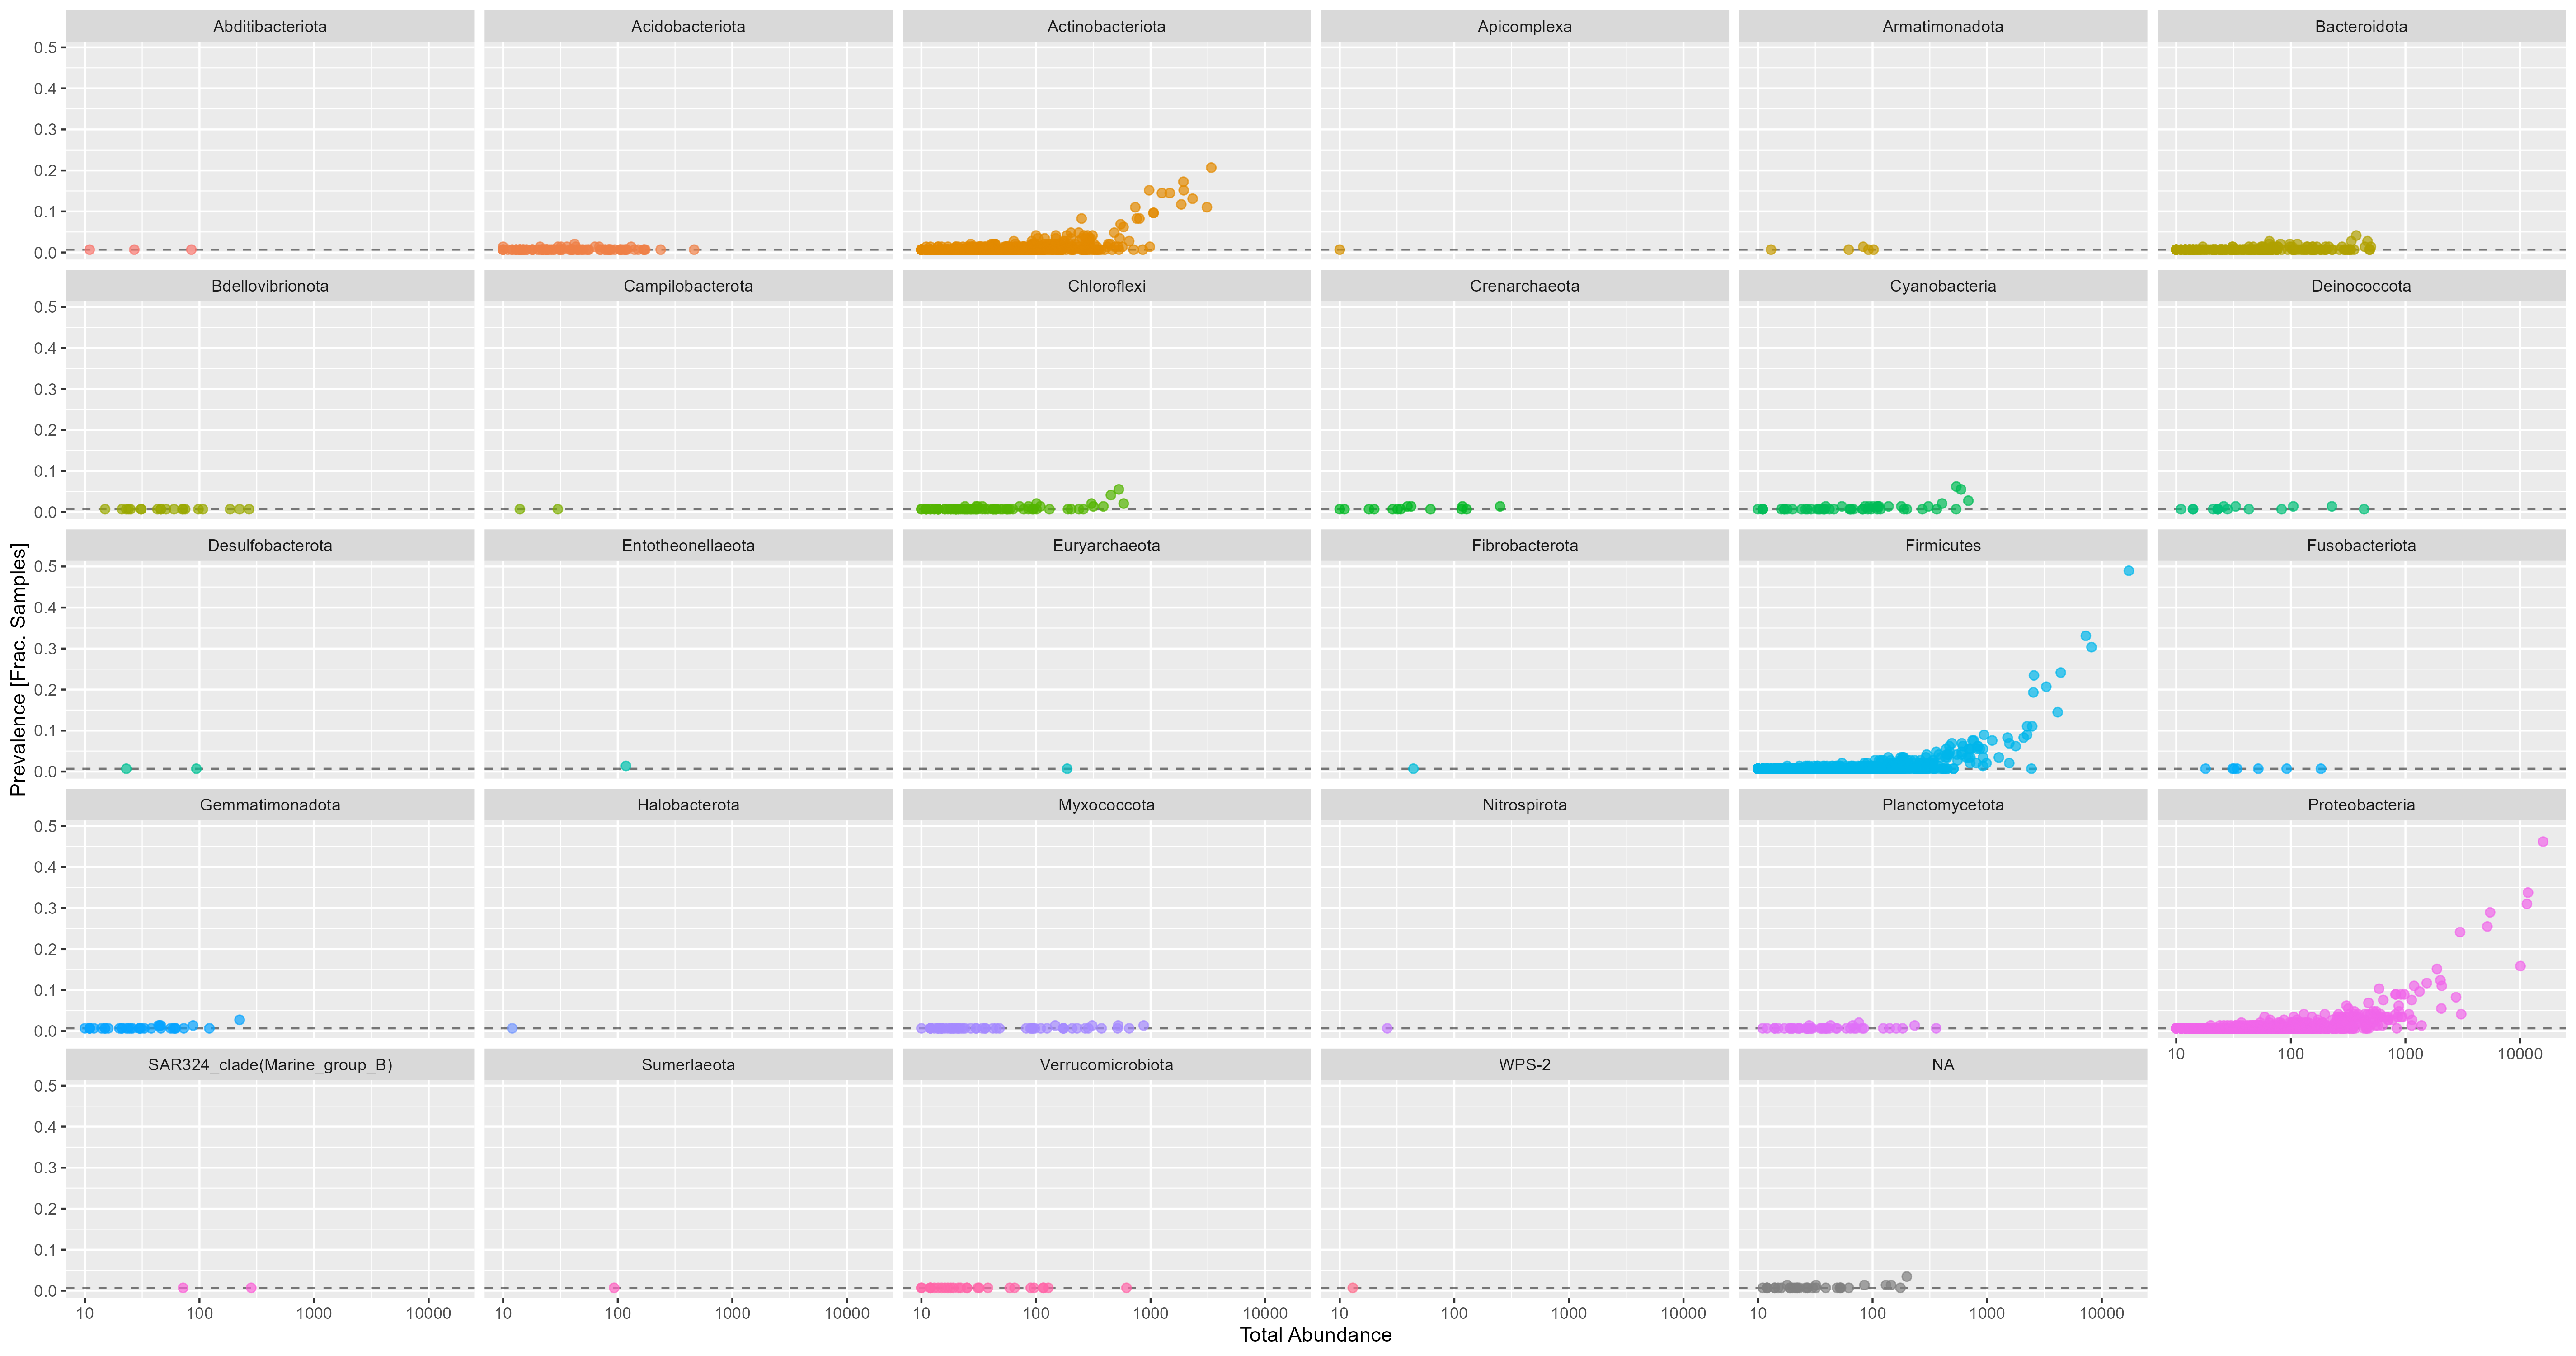

In [ ]:
#Execute prevalence filter
keepTaxa <- rownames(prevdf1)[(prevdf1$Prevalence >= 2)] 
ps.prevF <- prune_taxa(keepTaxa, ps)

### Rarefy

In [ ]:
#Set seed, check the sample with the lowest read count
set.seed(1997)

sort(sample_sums(ps.prevF))

#Rarefy n number of reads where n = read count of samples with fewest reads
ps.prevF.rar <- rarefy_even_depth(ps.prevF, sample.size = 518)

Based on rarefaction plot from QIIME2 and sample sums, a sequencing depth of 518 was chosen as the minimum depth.

This lead to the removal of 31 samples which did not meet the minumum sequencing depth. This removed 8 OTUs which were now no longer present in any samples.

### Fig 2 - Taxanomic Barplots (Family)

First, prepare data to show relative abundance at the Family level.

In [ ]:
library(ggh4x)
library(ggtext)

#Collapse to family level
ps.family <- tax_glom(ps.prevF.rar, taxrank = "Family", NArm = FALSE)

#Extract top 20 most abundant family names, bind to ps sampledata
top20families = names(sort(taxa_sums(ps.family), TRUE)[1:21])
taxtab20 = cbind(tax_table(ps.family), family_20 = NA)
taxtab20[top20families, "family_20"] <- as(tax_table(ps.family)
                                           [top20families, "Family"], "character")
tax_table(ps.family) <- tax_table(taxtab20)

ps.family.ra <- transform_sample_counts(ps.family, function(x) 100 * x/sum(x))

#Melt into a dataframe
pd.family <- psmelt(ps.family.ra)

#Replace NA with 'other', for plotting purposes
pd.family <- arrange(pd.family, day)
pd.family$family_20[is.na(pd.family$family_20)] <- c("Other")

#Relative abundance of top 20 families?
mean(sample_sums(prune_taxa(top20families, ps.family.ra)))

Then plot!

In [ ]:
library(RColorBrewer)
# Define the number of colors you want
nb.cols <- 22
mycolors <- colorRampPalette(brewer.pal(8, "Set3"))(nb.cols)


#Plot em

BarPlot1 <- ggplot(pd.family, aes(x = reorder(sample.group, day), y = (Abundance),
                      fill = fct_reorder(family_20, -Abundance))) +
  geom_bar(width = 0.9, stat = "identity", position="fill") +
  facet_nested(~pma.treatment + fung.treatment, scales = "free", space = "free", ) +
  labs(x = "", y = "Relative abundance") +
  theme(
    axis.text.y = element_text(size=14, face = 'bold'),
    axis.title.y = element_text(size=14, face = 'bold'),
    axis.ticks.y = element_line(size = 1),
    axis.ticks.x = element_line(size = 1),
    axis.text.x = element_text(size = 12),
    axis.title.x = element_blank(),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "bottom",
    strip.background = element_blank(),
    strip.text = element_textbox_simple(
      padding = margin(5, 0, 5, 0),
      margin = margin(5, 5, 5, 5),
      size = 10,
      face = "bold",
      halign = 0.5,
      fill = "white",
      box.color = "grey",
      linewidth = 1.5,
      linetype = "solid",),
    panel.background = element_blank()
  ) +
  scale_fill_manual(values = mycolors)+
  scale_y_continuous(labels = scales::percent, expand = c(0, 0)) +
  scale_x_discrete(labels = c("0","1","7","14","21"))

  #Save!
  ggsave(filename = "R_output/Figure2.png", 
       width = 15, height = 10, dpi = 300)

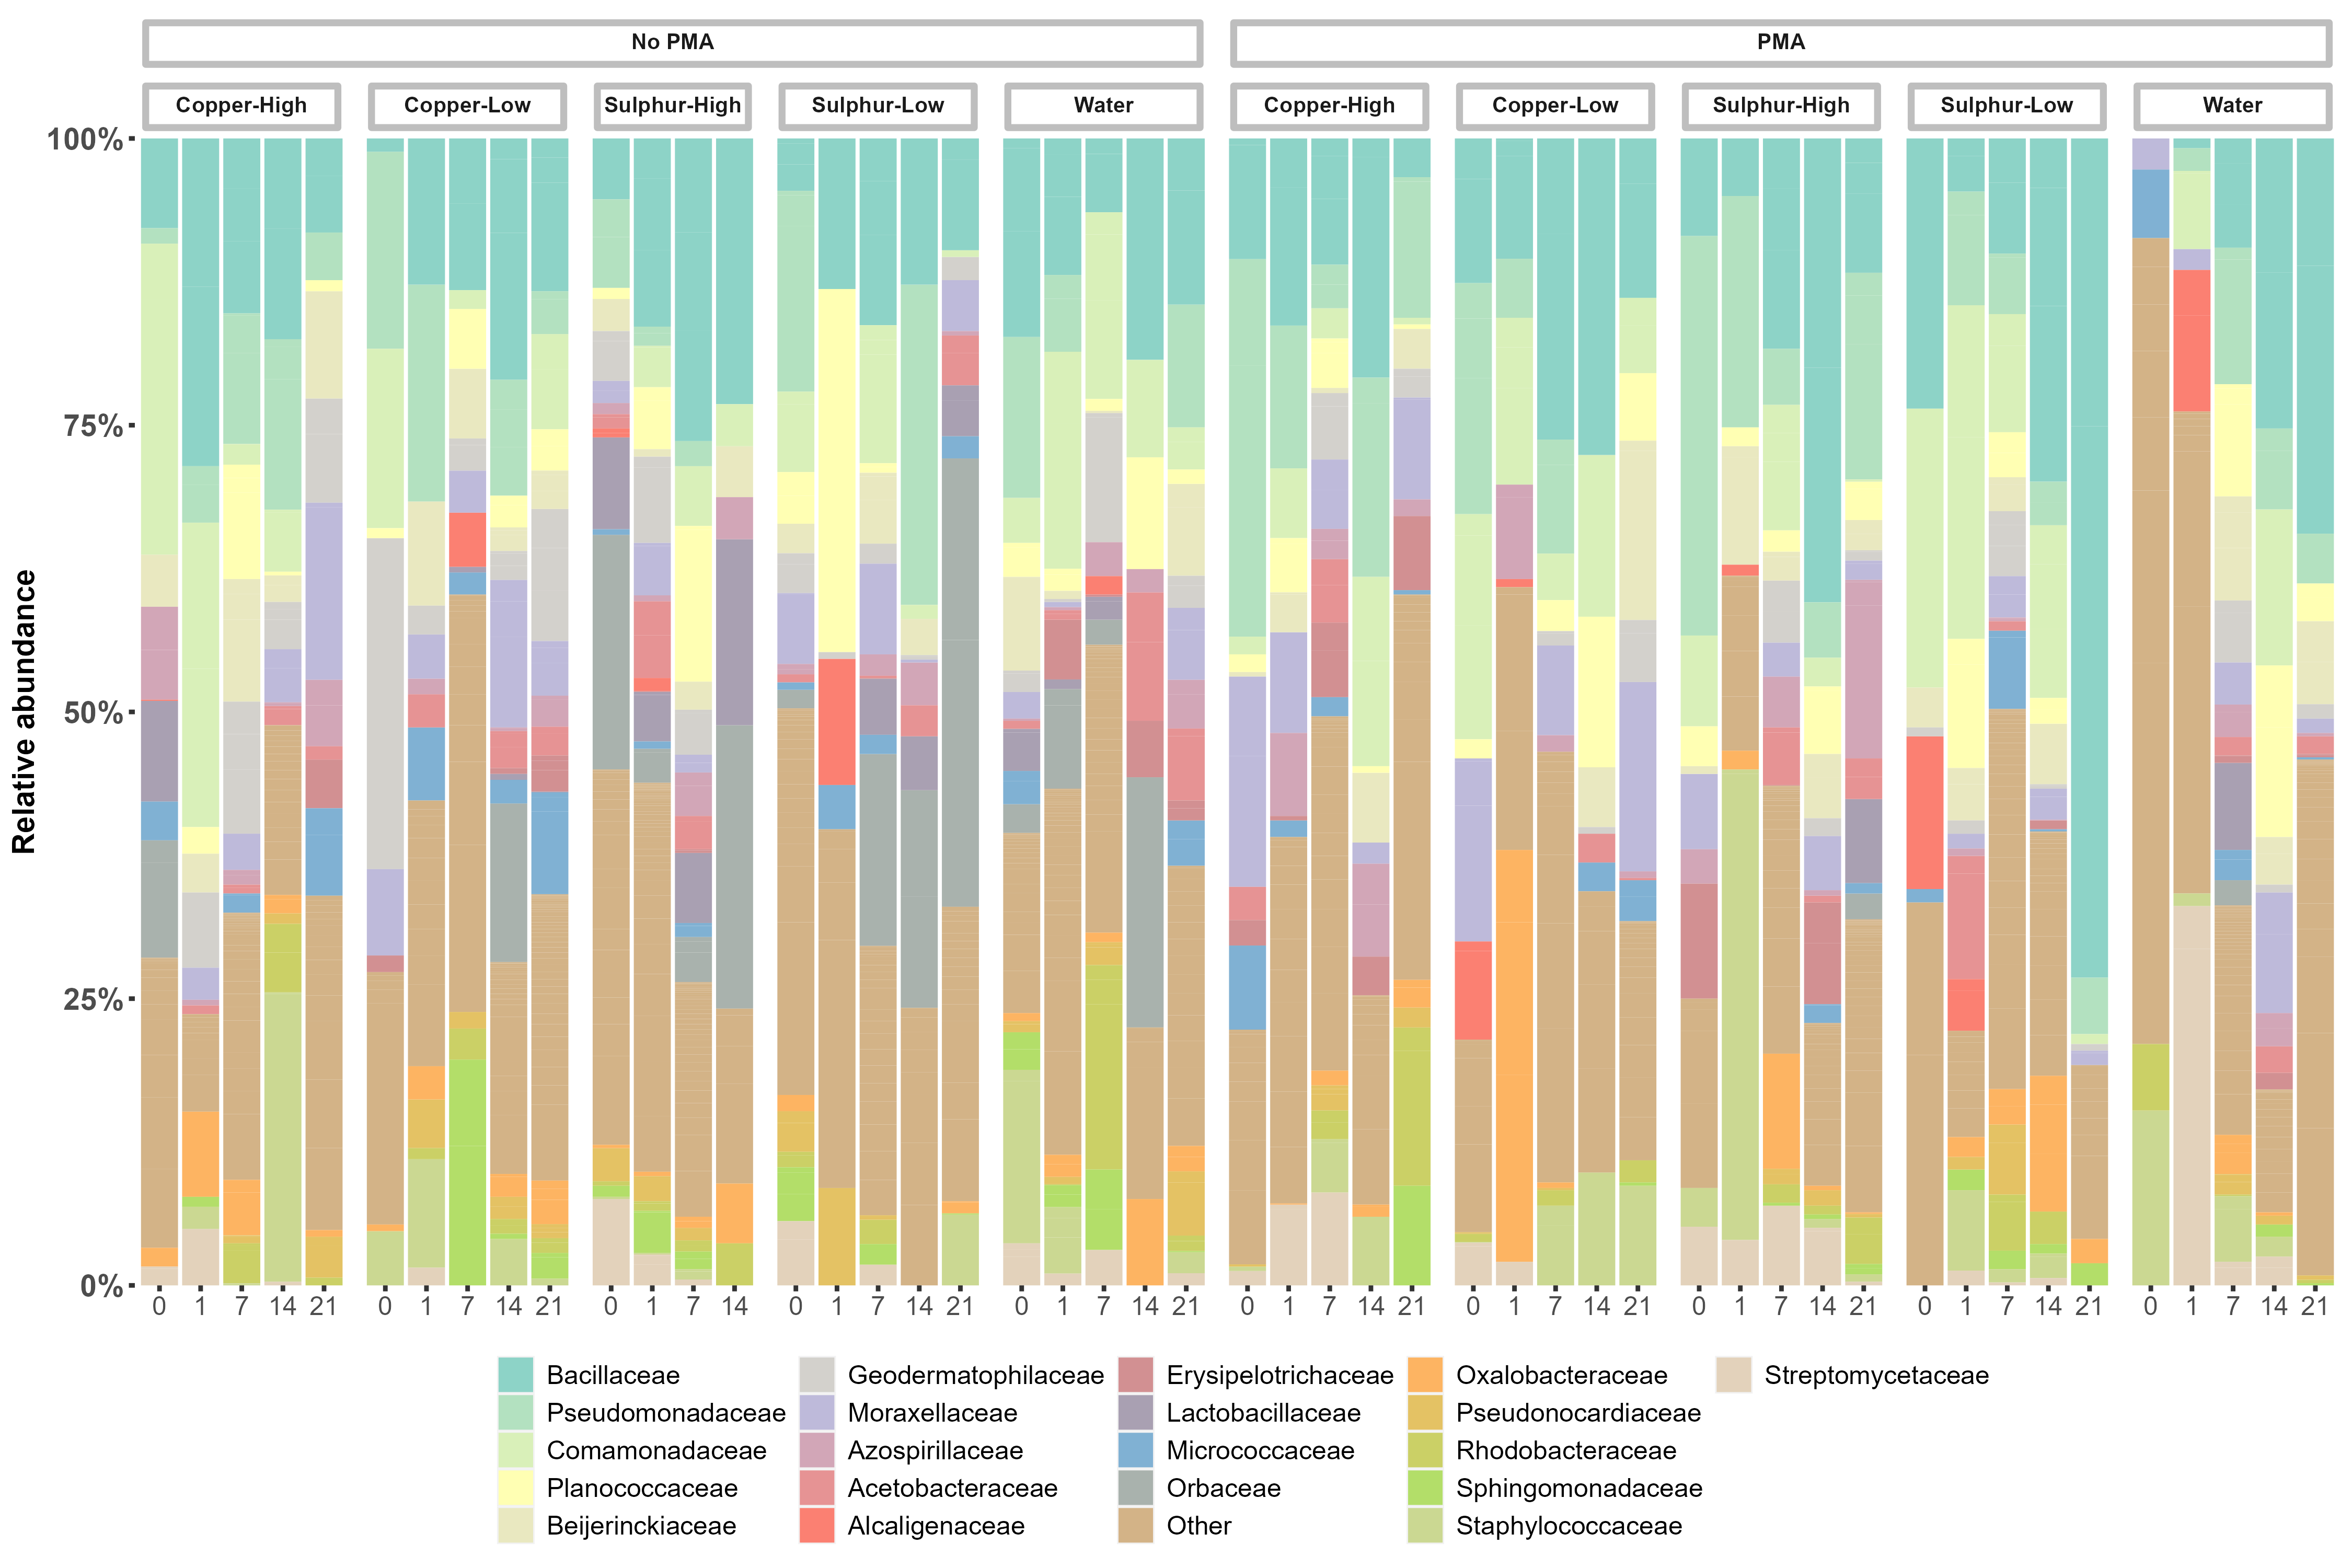

### Calculate Alpha Diversity Statistics

In [ ]:
# Generate Alpha statistics:
ps.rar.div <- alpha(ps.prevF.rar, index = c('observed', 'shannon', 'simpson'))

#Append metadata to alpha diversity values
ps.rar.meta <- meta(ps.prevF.rar)
ps.rar.meta$name <- rownames(ps.rar.meta)
ps.rar.div$name <- rownames(ps.rar.div)
ps.rar.div.df <- merge(ps.rar.div, ps.rar.meta, by = "name")

### Fig 4 - 16S Alpha Diversity Over Time

In [ ]:
#Set ggplot theme
theme_RE <- theme(axis.text.x = element_text(size=20), 
                  axis.text.y = element_text(size=20),
                  axis.title.x = element_text(size=24, face="bold"),
                  axis.title.y = element_text(size=24, face="bold"),
                  axis.line = element_line(colour = "black"),
                  #Background panel
                  panel.background = element_rect(fill = "White"),
                  panel.grid.major = element_line(colour = "white"), 
                  panel.grid.minor = element_line(colour = "white"),
                  #Legend
                  legend.title = element_blank(),
                  legend.text = element_text(size=16),
                  legend.key = element_rect(fill = "white", color = NA),
                  legend.position = c(0.5, 0.18),
                  legend.direction = "horizontal",
                  legend.key.size = unit(3.5, "line"))

#Set colours
CopperH <- c("#009E73", "#999999")
CopperL <- c("#00ad7f", "#999999")
SulphurH <- c("#E69F00", "#999999")
SulphurL <- c("#ffba24", "#999999")

#Set filter groups
W.Ch <- c("Water", "Copper-High")
W.Cl <- c("Water", "Copper-Low")
W.Sh <- c("Water", "Sulphur-High")
W.Sl <- c("Water", "Sulphur-Low")


## Shannon Diversity Plots

plot.diversity.CopperH <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Ch) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=CopperH)

plot.diversity.CopperL <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Cl) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=CopperL)

plot.diversity.SulphurH <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Sh) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=SulphurH)

plot.diversity.SulphurL <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Sl) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("Day") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=SulphurL)


## Richness Plots

plot.richness.CopperH <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Ch) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=CopperH)

plot.richness.CopperL <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Cl) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=CopperL)

plot.richness.SulphurH <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Sh) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=SulphurH)

plot.richness.SulphurL <- ps.rar.div.df %>%
  filter(pma.treatment == "TRUE") %>%
  filter(fung.treatment %in% W.Sl) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("Day") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=SulphurL)


#Arrange plots together
ggarrange(plot.diversity.CopperH, plot.richness.CopperH,
          plot.diversity.CopperL, plot.richness.CopperL,
          plot.diversity.SulphurH, plot.richness.SulphurH,
          plot.diversity.SulphurL, plot.richness.SulphurL,
          nrow = 4, ncol = 2, common.legend = FALSE)

#Save
ggsave(filename = "R_output/Figure4.png", 
       width = 16, height = 20, dpi = 300)


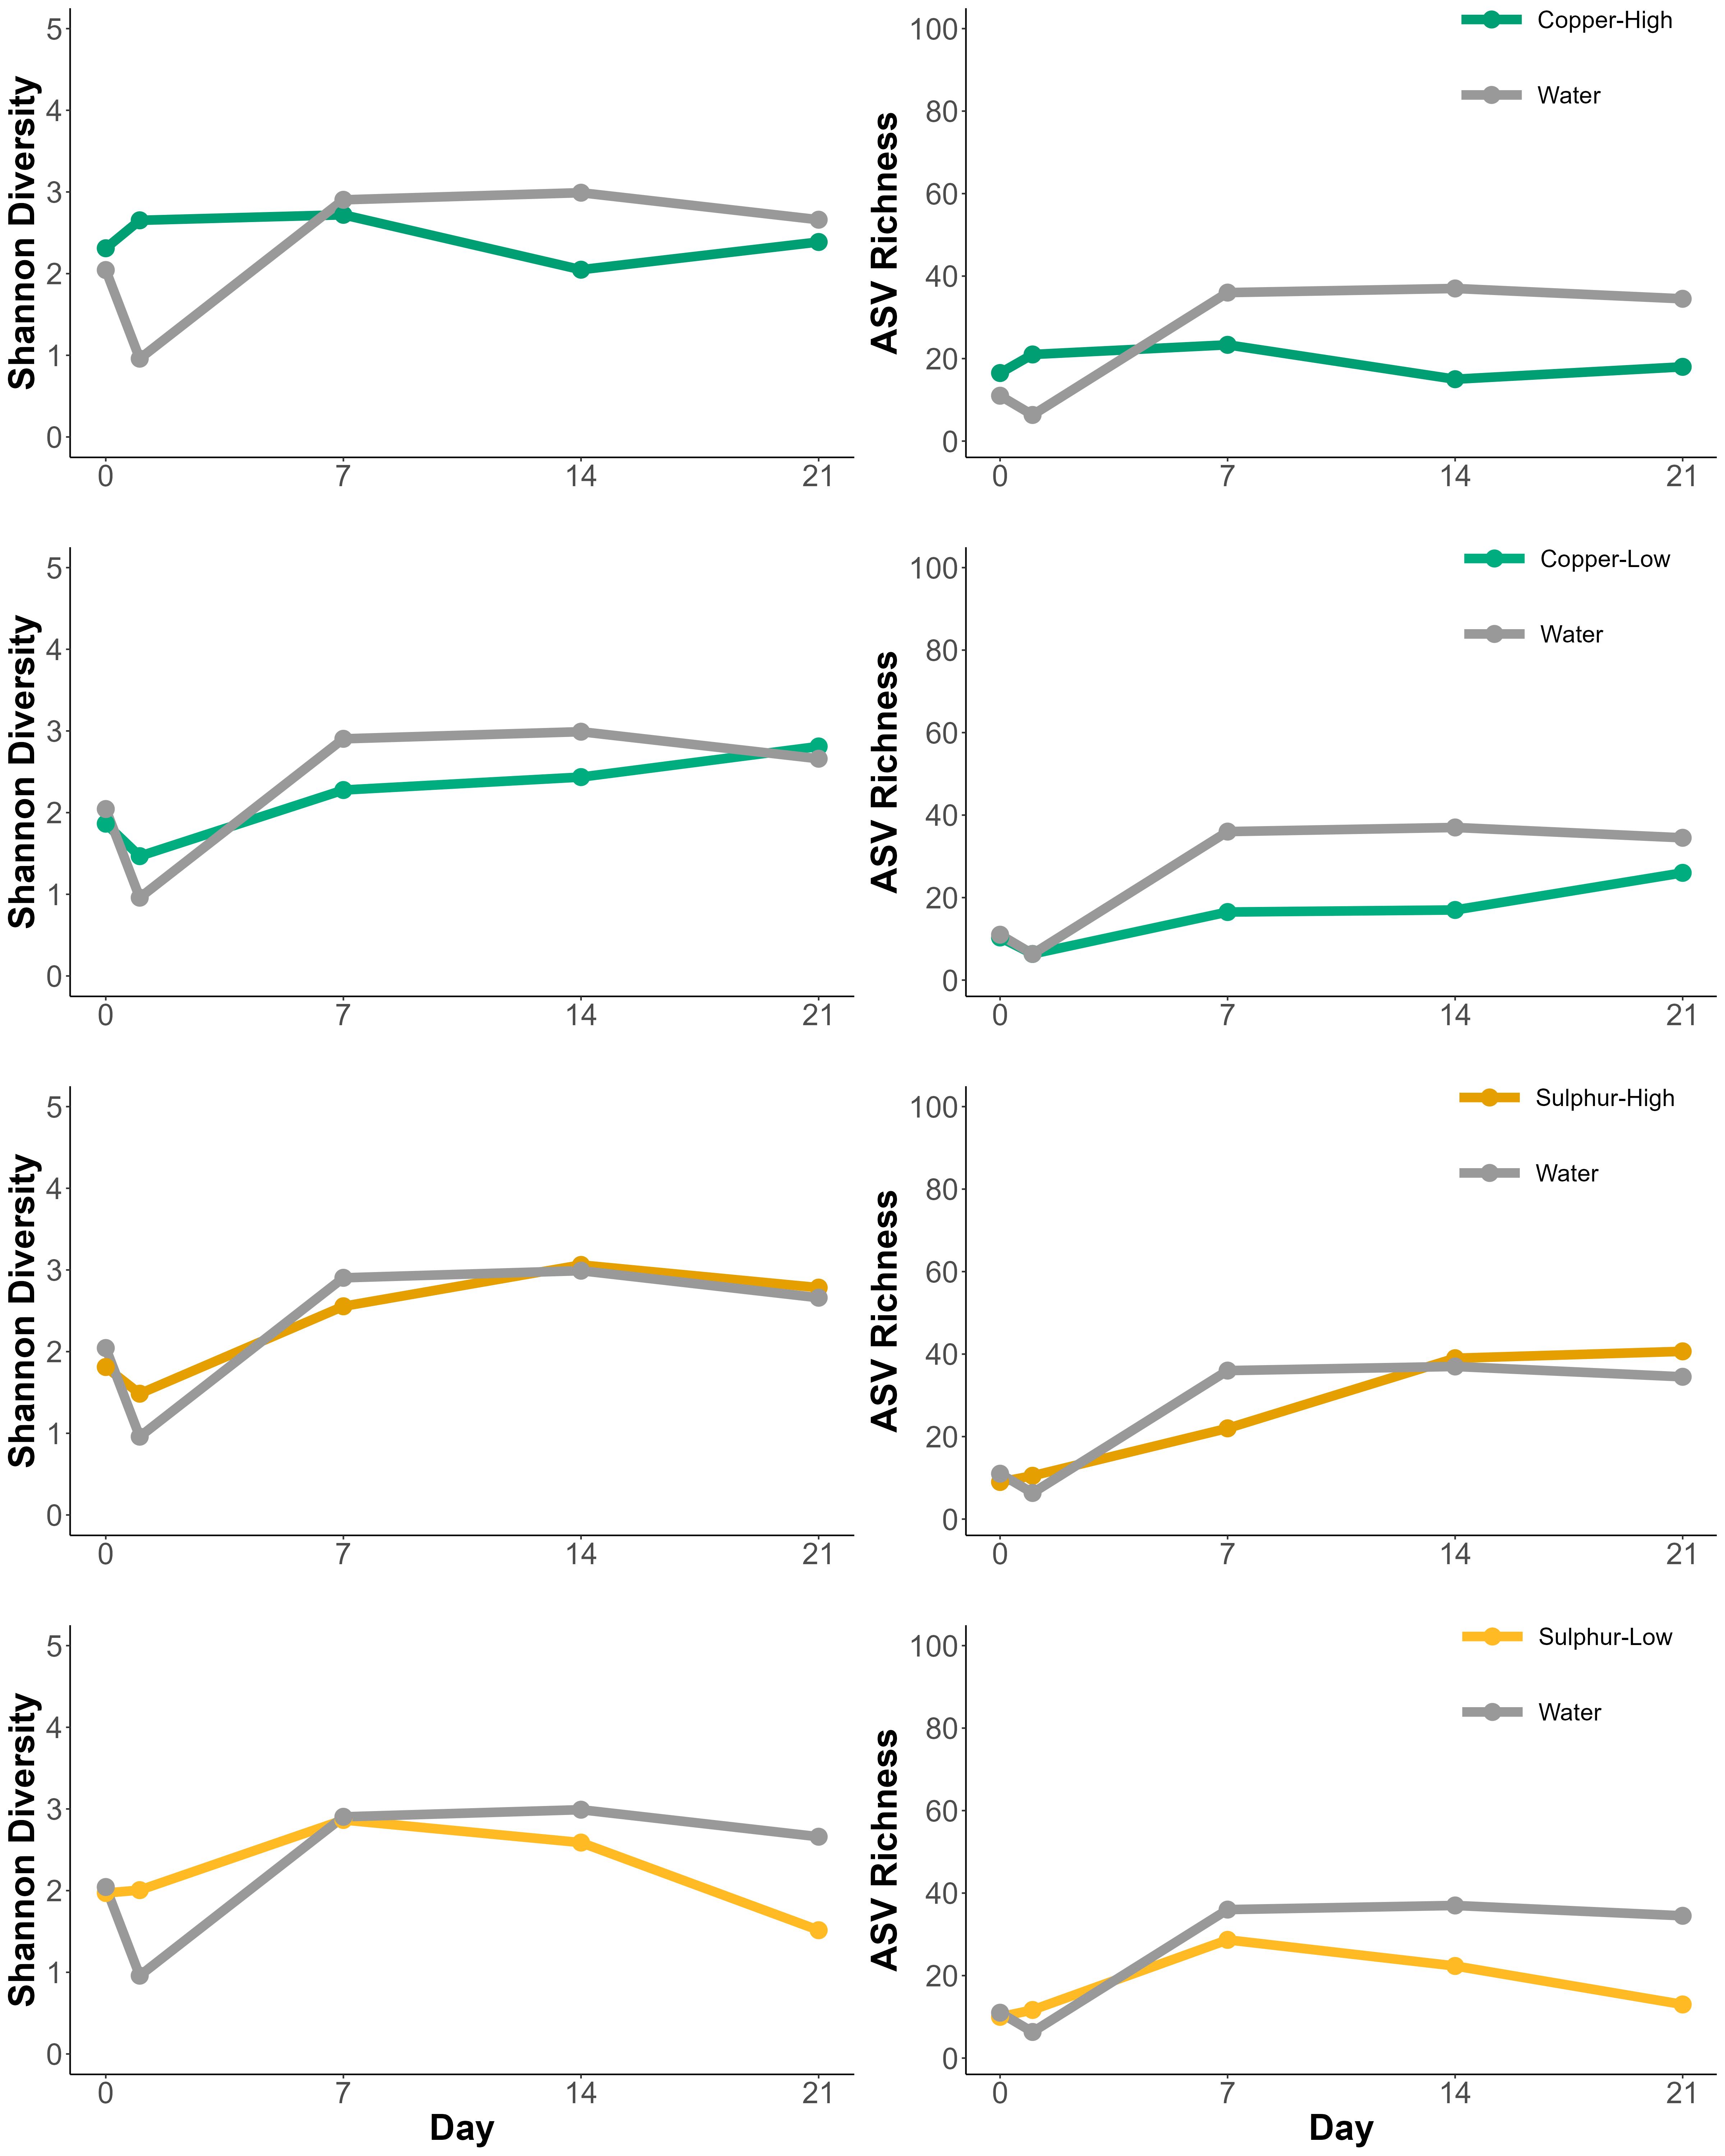

### Supplementary Fig 1: 16S Taxa Barplots (Phylum)

In [ ]:
library(ggh4x)
library(ggtext)

#Collapse to phylum level
ps.phylum <- tax_glom(ps.prevF.rar, taxrank = "Phylum", NArm = FALSE)
ps.phylum.ra <- transform_sample_counts(ps.phylum, function(x) 100 * x/sum(x))

#Melt into a dataframe
pd.phylum <- psmelt(ps.phylum.ra)

library(RColorBrewer)
# Define the number of colors you want
nb.cols <- 22
mycolors <- colorRampPalette(brewer.pal(8, "Set3"))(nb.cols)


#Plot em

BarPlot2 <- ggplot(pd.phylum, aes(x = reorder(sample.group, day), y = (Abundance),
                                  fill = fct_reorder(Phylum, -Abundance))) +
  geom_bar(width = 0.9, stat = "identity", position="fill") +
  facet_nested(~pma.treatment + fung.treatment, scales = "free", space = "free", ) +
  labs(x = "", y = "Relative abundance") +
  theme(
    axis.text.y = element_text(size=14, face = 'bold'),
    axis.title.y = element_text(size=14, face = 'bold'),
    axis.ticks.y = element_line(size = 1),
    axis.ticks.x = element_line(size = 1),
    axis.text.x = element_text(size = 12),
    axis.title.x = element_blank(),
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    legend.position = "bottom",
    strip.background = element_blank(),
    strip.text = element_textbox_simple(
      padding = margin(5, 0, 5, 0),
      margin = margin(5, 5, 5, 5),
      size = 10,
      face = "bold",
      halign = 0.5,
      fill = "white",
      box.color = "grey",
      linewidth = 1.5,
      linetype = "solid",),
    panel.background = element_blank()
  ) +
  scale_fill_manual(values = mycolors)+
  scale_y_continuous(labels = scales::percent, expand = c(0, 0)) +
  scale_x_discrete(labels = c("0","1","7","14","21"))

# Save!
ggsave(filename = "R_output/SuppFig1.png", 
       width = 15, height = 10, dpi = 300)

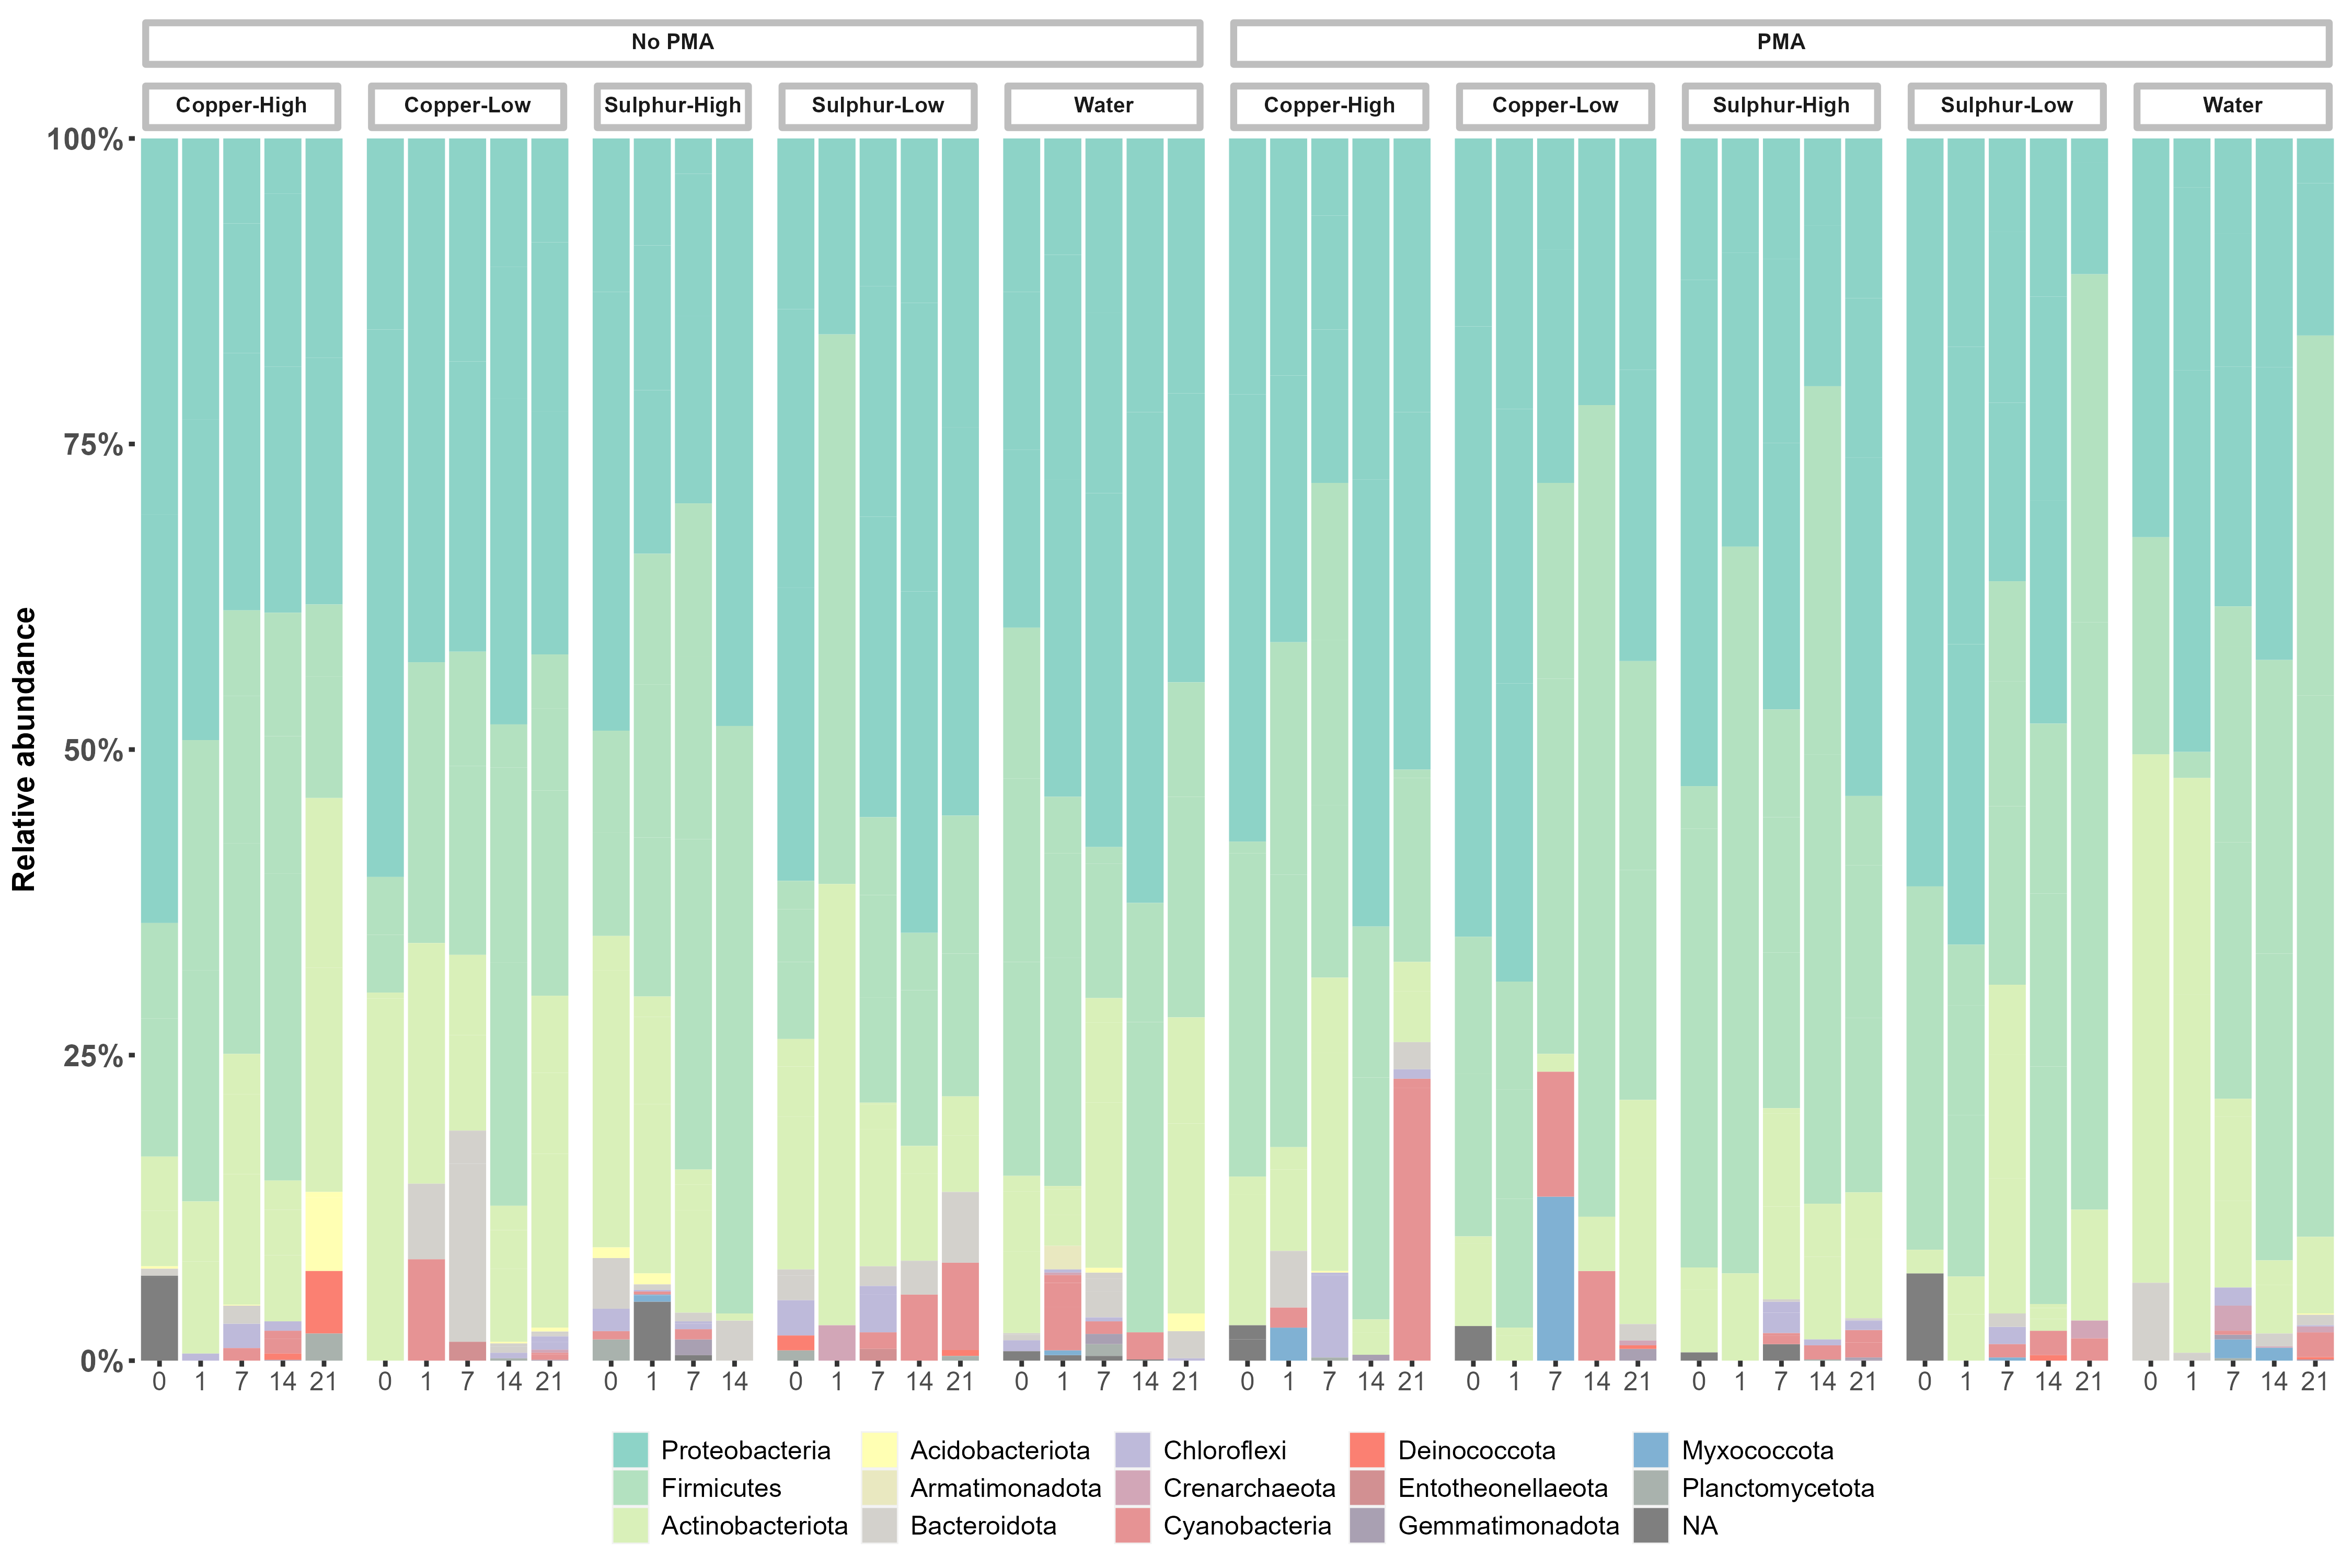

### Supplementary Fig 3: 16S Alpha Diversity Over Time (No PMA Treatment)

In [ ]:
## Shannon Diversity Plots

plot.diversity.CopperH <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Ch) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=CopperH)

plot.diversity.CopperL <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Cl) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=CopperL)


plot.diversity.SulphurH <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Sh) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=SulphurH)


plot.diversity.SulphurL <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Sl) %>%
  ggplot(aes(x=day, y=diversity_shannon, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(0, 5), breaks = seq(0, 5, 1)) +
  xlab("Day") +
  ylab("Shannon Diversity") +
  theme_RE +
  theme(legend.position='none') +
  scale_color_manual(values=SulphurL)


## Richness Plots

plot.richness.CopperH <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Ch) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=CopperH)


plot.richness.CopperL <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Cl) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=CopperL)


plot.richness.SulphurH <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Sh) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=SulphurH)


plot.richness.SulphurL <- ps.rar.div.df %>%
  filter(pma.treatment != "TRUE") %>%
  filter(fung.treatment %in% W.Sl) %>%
  ggplot(aes(x=day, y=observed, color=fung.treatment)) +
  geom_line(stat = "summary", fun = "mean", size = 3) +
  geom_point(stat = "summary", fun = "mean", size = 5) +
  scale_x_continuous(breaks = seq(0, 21, 7)) +
  scale_y_continuous(limits = c(1, 100), breaks = seq(0, 100, 20)) +
  xlab("Day") +
  ylab("ASV Richness") +
  theme_RE +
  theme(legend.direction = 'vertical') +
  theme(legend.position = c(0.8,0.9)) +
  scale_color_manual(values=SulphurL)


#Arrange plots together
ggarrange(plot.diversity.CopperH, plot.richness.CopperH,
          plot.diversity.CopperL, plot.richness.CopperL,
          plot.diversity.SulphurH, plot.richness.SulphurH,
          plot.diversity.SulphurL, plot.richness.SulphurL,
          nrow = 4, ncol = 2, common.legend = FALSE)

#Save
ggsave(filename = "R_output/SuppFig3.png", 
       width = 16, height = 20, dpi = 300)

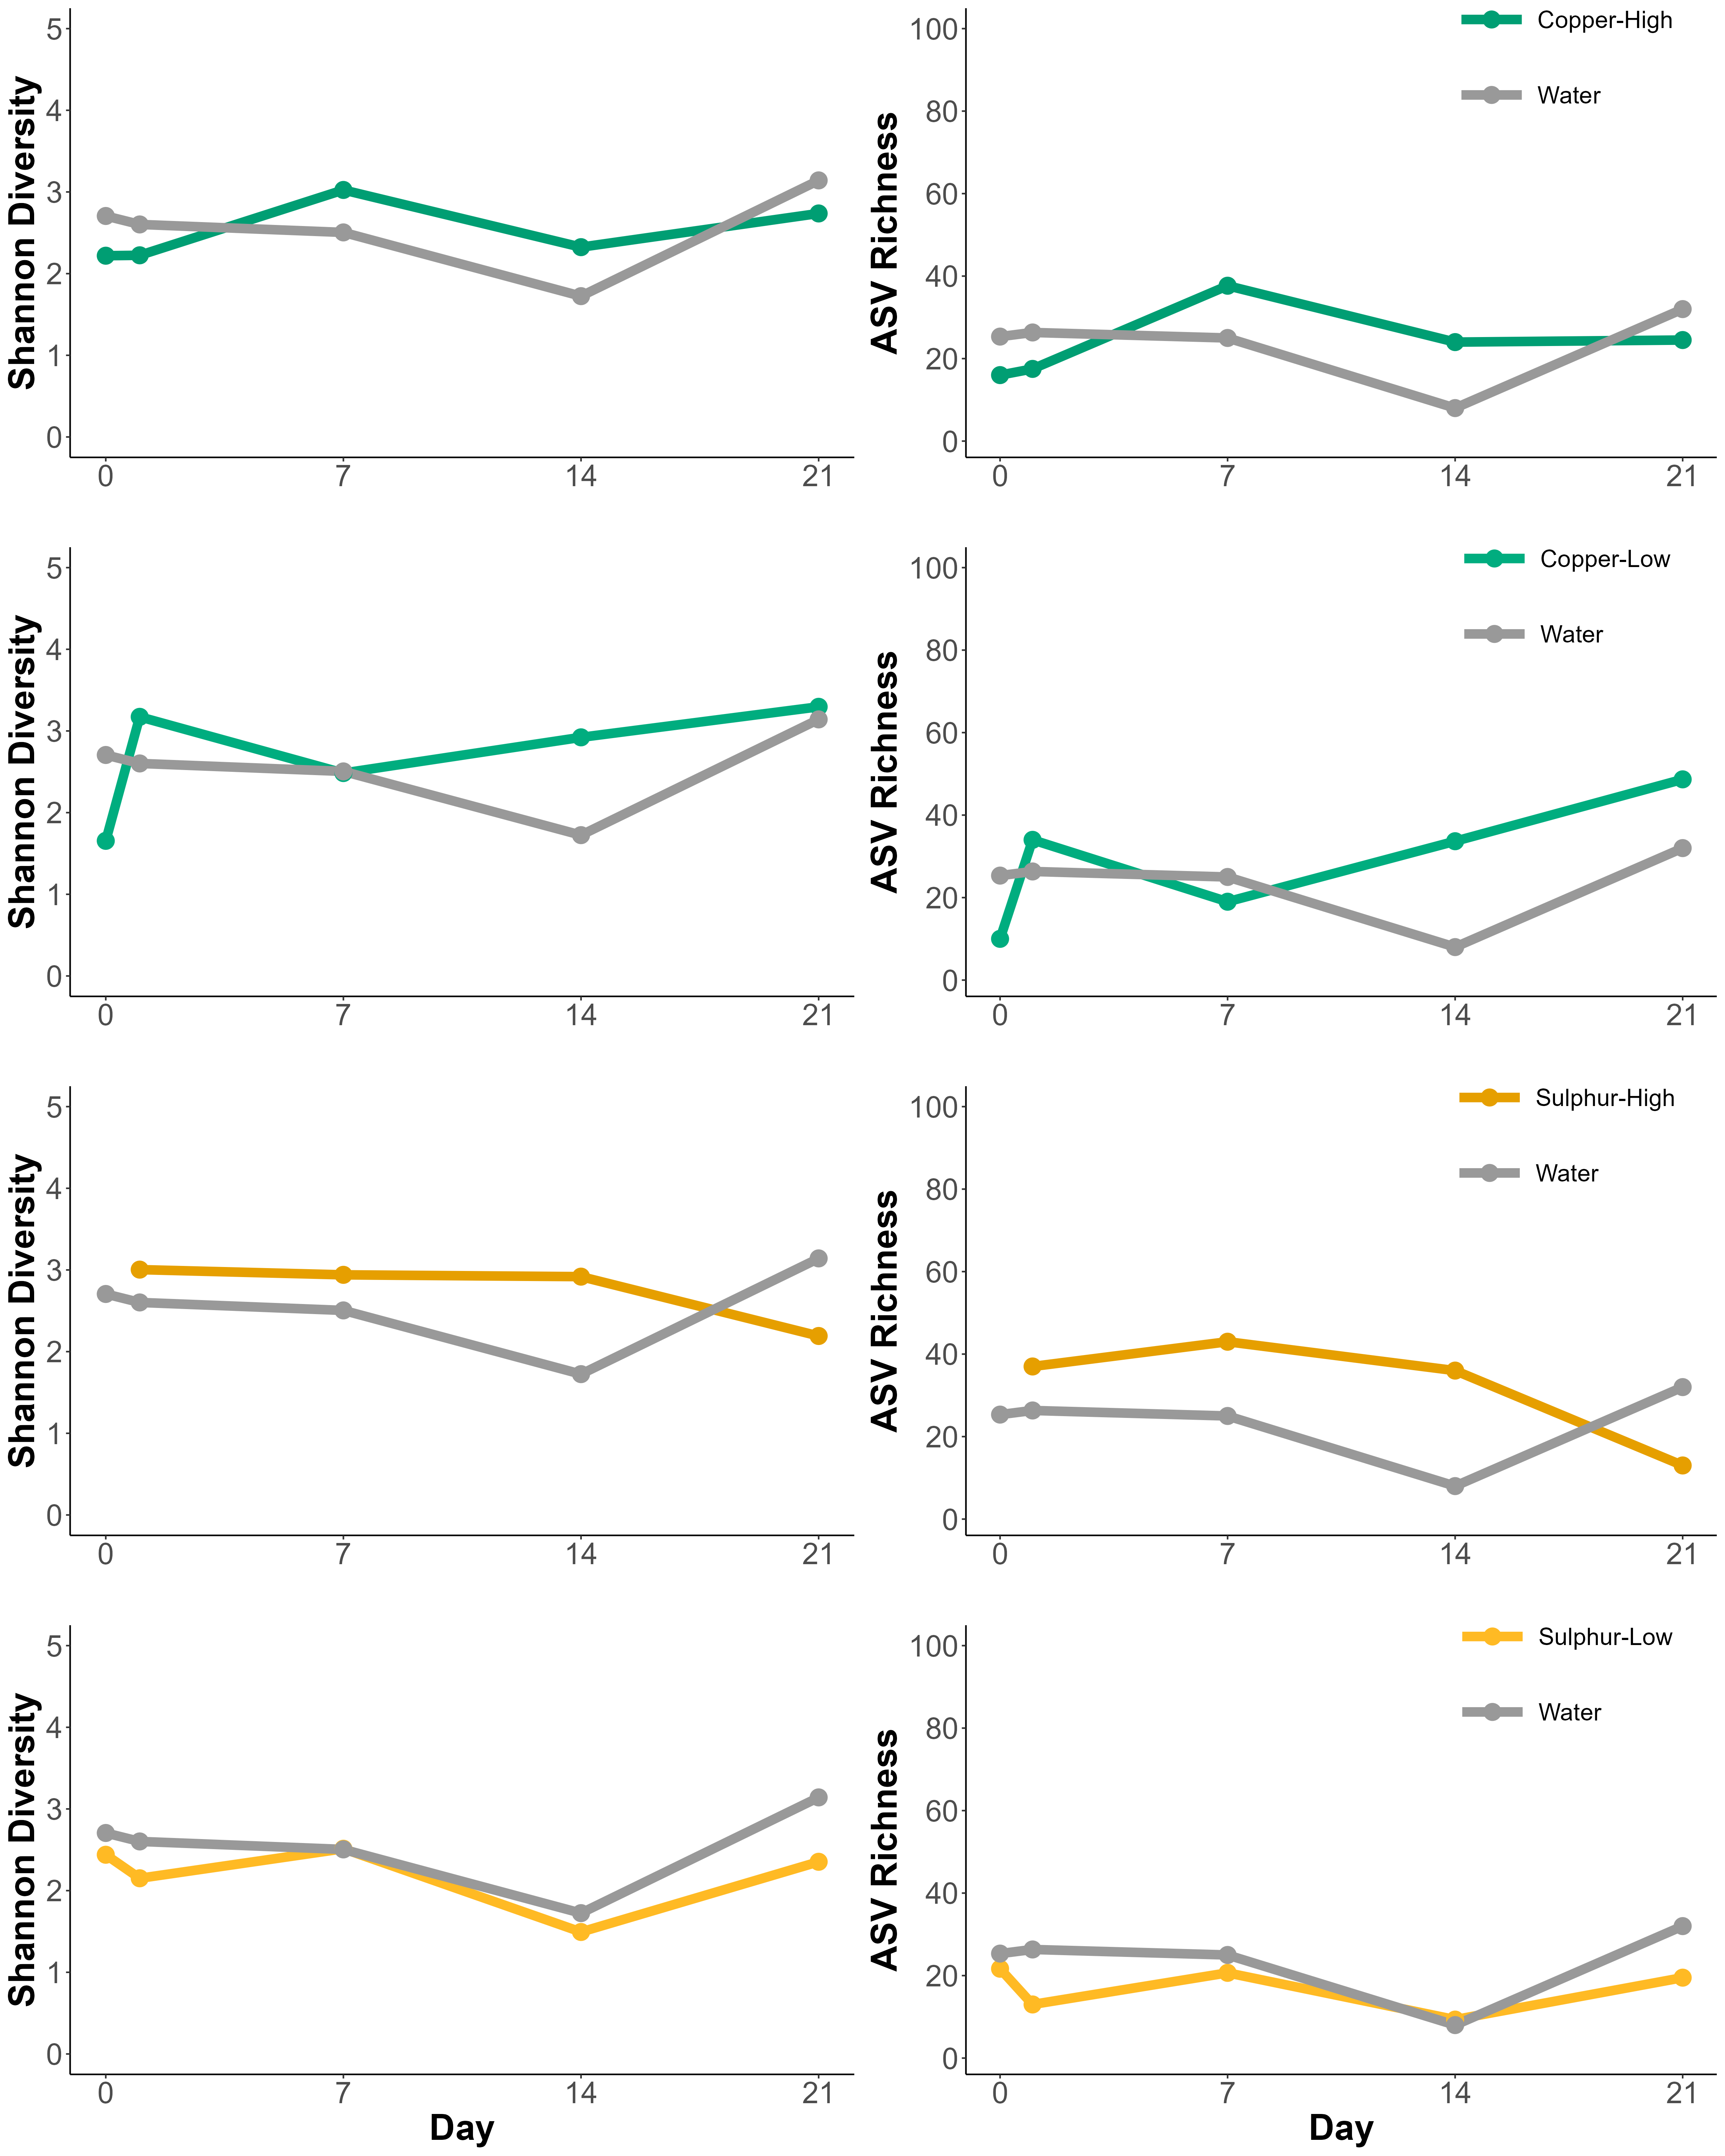